# Exporting the bike project

This notebook demonstrates how to export a full project either as an excel file or a backup.

In [1]:
import bw2data as bd
import bw2io as bi

15:23:33+0100 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


In [2]:
# work in the "right" projo
bd.projects

Brightway2 projects manager with 4 objects:
	Bicycle example
	default
	ecoinvent-3.11-cutoff-bw25
	electric_vehicle_standalone
Use `projects.report()` to get a report on all projects.

In [3]:
bd.projects.set_current('Bicycle example')

In [4]:
bd.databases

Databases dictionary with 1 object(s):
	🚲

In [5]:
for a in bd.Database('🚲'):
    print(a)

'natural gas production' (None, NO, None)
'bicycle' (number, GLO, None)
'natural gas' (megajoule, GLO, None)
'carbon fibre production' (None, DE, None)
'bike production' (None, DK, None)
'carbon fibre' (kilogram, GLO, None)
'Carbon Dioxide' (kilogram, GLO, ('air',))


## Exporting

### Option 1 - Excel 

In [6]:
from bw2io.export import write_lci_excel
import sys

In [7]:
# We will specify the path where we want the excel file to end-up
# in particular, we want it to be in the "home" directory of the user executing this notebook
from pathlib import Path
home = Path.home()

In [8]:
home

PosixPath('/home/jupyter-rosalia')

In [ ]:
write_lci_excel?

In [9]:
write_lci_excel('🚲', dirpath=home)

'/home/jupyter-rosalia/lci-.xlsx'

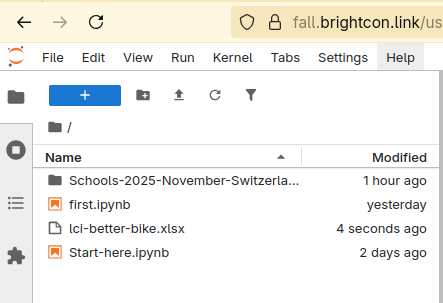

### Option 2 backup the full project directory

In [27]:
bi.backup_project_directory?

Signature:
bi.backup_project_directory(
    project: str,
    timestamp: Optional[bool] = True,
    dir_backup: Union[str, pathlib.Path, NoneType] = None,
) -> pathlib.Path
Docstring:
Backup project data directory to a ``.tar.gz`` (compressed tar archive) in the user's home directory, or a directory specified by ``dir_backup``.

File name is of the form ``brightway2-project-{project}-backup{timestamp}.tar.gz``, unless ``timestamp`` is False, in which case the file name is ``brightway2-project-{project}-backup.tar.gz``.

Parameters
----------
project : str
    Name of the project to backup.

timestamp : bool, optional
    If True, append a timestamp to the backup file name.

dir_backup : str, Path, optional
    Directory to backup. If None, use the default (home)).

Returns
-------
filepath : Path
    pathlib.Path of archive file

Raises
------
ValueError
   If the project does not exist.
FileNotFoundError
    If the backup directory does not exist.
PermissionError
    If the backup dir

In [28]:
full_project_file = bi.backup_project_directory(bd.projects.current, dir_backup=home)
full_project_file

Creating project backup archive - this could take a few minutes...
Saved to: /home/jupyter-rosalia/brightway2-project-Bicycle example-backup11-November-2025-03-41PM.tar.gz


PosixPath('/home/jupyter-rosalia/brightway2-project-Bicycle example-backup11-November-2025-03-41PM.tar.gz')

## Import

### an Excel file

In [10]:
importer = bi.ExcelImporter?

Init signature: bi.ExcelImporter(filepath)
Docstring:     
Generic Excel importer.

Excel spreadsheet should follow the following format:

::
    Project parameters
    <variable>, <formula>, <amount>, metadata

    Database, <name of database>
    <database field name>, <database field value>

    Parameters
    <variable>, <formula>, <amount>, metadata

    Activity, <name of activity>
    <database field name>, <database field value>
    Exchanges
    <field name>, <field name>, <field name>
    <value>, <value>, <value>
    <value>, <value>, <value>

Neither project parameters, parameters, nor exchanges for each activity are required.

An activity is marked as finished with a blank line.

In general, data is imported without modification. However, the following transformations are applied:

* Numbers are translated from text into actual numbers.
* Tuples, separated in the cell by the ``::`` string, are reconstructed.
* ``True`` and ``False`` are transformed to boolean values.
* Fie

In [11]:
from pathlib import Path
home = Path.home()

bike_projo_importer = bi.ExcelImporter(home / "lci-.xlsx")

Extracted 1 worksheets in 0.00 seconds


In [12]:
# regular bw pattern: apply strategies, identify "unlinked" (and fix 'em if necessary)
# and then write

bike_projo_importer.apply_strategies()

Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories


MissingMigration: Migration `biosphere-2-3-categories` is missing; did you run `bw2setup()` in this project? You can also (re-)install core migrations  with `create_core_migrations()`

In [13]:
# If the previous step gave an error regarding "create_core_migrations", we do:
bi.create_core_migrations()

In [14]:
bike_projo_importer.apply_strategies()

Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.00 seconds


In [15]:
bike_projo_importer.statistics()

Graph statistics for `🚲` importer:
7 graph nodes:
	product: 3
	process: 3
	emission: 1
6 graph edges:
	production: 3
	technosphere: 2
	biosphere: 1
5 edges to the following databases:
	🚲: 5
1 unique unlinked edges (1 total):
	biosphere: 1




(7, 6, 1, 0)

In [16]:
# Now, some exchanges are unlinked, we can fix this in code, or directly in the excel file.
# Code now!

bd.databases

Databases dictionary with 1 object(s):
	🚲

In [ ]:
# Which are the unlinked ?

In [17]:
for u in bike_projo_importer.unlinked:
    print(u)

{'name': 'Carbon Dioxide', 'amount': 26.6, 'unit': 'kilogram', 'categories': ('air',), 'type': 'biosphere', 'minimum': 26, 'maximum': 27.2, 'uncertainty_type': 5}


In [18]:
# fix the unlinks by matching to the database nodes that we are importing
bike_projo_importer.match_database()

Applying strategy: link_iterable_by_fields


In [19]:
bike_projo_importer.statistics()

Graph statistics for `🚲` importer:
7 graph nodes:
	product: 3
	process: 3
	emission: 1
6 graph edges:
	production: 3
	technosphere: 2
	biosphere: 1
5 edges to the following databases:
	🚲: 5
1 unique unlinked edges (1 total):
	biosphere: 1




(7, 6, 1, 0)

In [20]:
# fix the unlinks by matching to the database nodes that we are importing
bike_projo_importer.match_database('🚲')

Applying strategy: link_iterable_by_fields


In [21]:
bike_projo_importer.statistics()

Graph statistics for `🚲` importer:
7 graph nodes:
	product: 3
	process: 3
	emission: 1
6 graph edges:
	production: 3
	technosphere: 2
	biosphere: 1
5 edges to the following databases:
	🚲: 5
1 unique unlinked edges (1 total):
	biosphere: 1




(7, 6, 1, 0)

In [ ]:
# Going manual because automatic can't help

In [22]:
for document in bike_projo_importer:
    print(document['name'])
    for exchange in document.get('exchanges', []):
        print(exchange)

Carbon Dioxide
bicycle
bike production
{'name': 'bicycle', 'amount': 1, 'location': 'GLO', 'unit': 'number', 'type': 'production', 'functional': 1, 'input': ('🚲', '1362a632b008459c8f3aa3425c454bbc')}
{'name': 'carbon fibre', 'amount': 2.5, 'location': 'GLO', 'unit': 'kilogram', 'type': 'technosphere', 'input': ('🚲', 'cf')}
carbon fibre
carbon fibre production
{'name': 'Carbon Dioxide', 'amount': 26.6, 'unit': 'kilogram', 'categories': ('air',), 'type': 'biosphere', 'minimum': 26, 'maximum': 27.2, 'uncertainty_type': 5}
{'name': 'carbon fibre', 'amount': 1, 'location': 'GLO', 'unit': 'kilogram', 'type': 'production', 'functional': 1, 'input': ('🚲', 'cf')}
{'name': 'natural gas', 'amount': 237.3, 'location': 'GLO', 'unit': 'megajoule', 'type': 'technosphere', 'minimum': 200, 'maximum': 300, 'uncertainty_type': 5, 'input': ('🚲', 'b31e5ede4096483fb7043adadcd1208c')}
natural gas
natural gas production
{'name': 'natural gas', 'amount': 1, 'location': 'GLO', 'unit': 'megajoule', 'type': 'prod

In [23]:
for document in bike_projo_importer:
    if "Carbon Dioxide" in document['name']:
        print(document)
        co2_code = document['code']

{'categories': ('air',), 'code': '2d0a9d6358de4e66a923fc70ece5e6ff', 'location': 'GLO', 'type': 'emission', 'unit': 'kilogram', 'name': 'Carbon Dioxide', 'exchanges': [], 'worksheet name': '🚲', 'database': '🚲'}


In [24]:
for document in bike_projo_importer:
    for exchange in document.get('exchanges', []):
        if exchange.get('input', None) is None:
            print(f"Exchange unlinked: {exchange}")
            # We fix here by providing the required "input" (the database, code tuple)
            exchange['input'] = ('🚲', co2_code)

Exchange unlinked: {'name': 'Carbon Dioxide', 'amount': 26.6, 'unit': 'kilogram', 'categories': ('air',), 'type': 'biosphere', 'minimum': 26, 'maximum': 27.2, 'uncertainty_type': 5}


In [25]:
assert bike_projo_importer.all_linked

Graph statistics for `🚲` importer:
7 graph nodes:
	product: 3
	process: 3
	emission: 1
6 graph edges:
	production: 3
	technosphere: 2
	biosphere: 1
6 edges to the following databases:
	🚲: 6
0 unique unlinked edges (0 total):




In [26]:
bike_projo_importer.write_database()

100%|██████████| 7/7 [00:00<00:00, 29746.84it/s]

15:39:05+0100 [info     ] Vacuuming database            
Created database: 🚲


### a project backup

In [29]:
bi.restore_project_directory?

Signature:
bi.restore_project_directory(
    fp: Union[str, pathlib.Path],
    project_name: Optional[str] = None,
    overwrite_existing: Optional[bool] = False,
    switch: bool = False,
)
Docstring:
Restore a backed up project data directory from a ``.tar.gz`` (compressed tar archive) specified by ``fp``. Choose a custom name, or use the name of the project in the archive. If the project already exists, you must set ``overwrite_existing`` to True.

Parameters
----------
fp : str, Path
    File path of the project to restore.
project_name : str, optional
    Name of new project to create.
overwrite_existing : bool, optional
switch: bool, optional.
    Switch to new project after restoring it.

Returns
-------
project_name : str, Path
    Name of the project that was restored.

Raises
------
FileNotFoundError
    If the file path does not exist.
ValueError
    If the project name cannot be found in the archive.
    If the project exists and ``overwrite_existing`` is False.

See Also
-

In [32]:
# We re-use here the path where we backed-up the project `full_project_file`
# but you're free to provide your own path
# Also, we are going to change the name of the resulting project
bi.restore_project_directory(full_project_file, project_name="Another one bikes the dust", overwrite_existing=True)


Restoring project backup archive - this could take a few minutes...
Restored project: Another one bikes the dust


'Another one bikes the dust'

In [33]:
bd.projects.set_current('Another one bikes the dust')
bd.databases

Databases dictionary with 1 object(s):
	🚲

In [34]:
bd.methods

Methods dictionary with 1 object(s):
	('IPCC',)